In [1]:
import matplotlib.pyplot as plt
import urllib.request, json
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import wordpunct_tokenize

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

2024-09-19 23:10:31.950789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 23:10:31.972168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 23:10:31.972199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 23:10:31.985468: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 23:10:32.789054: W tensorflow/compiler/tf

Num GPUs Available:  0


2024-09-19 23:10:35.078325: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
plt.rcParams['figure.figsize'] = (5, 5)
plt.rc('font', size=5)

In [3]:
res = urllib.request.urlopen("http://127.0.0.1:8000/api/vagas?treinamento=true")
data = json.loads(res.read())
exemplos_treinamento = data['data']
qtd_pos = data['qtd_pos']
qtd_neg = data['qtd_neg']

In [4]:

def converteTextoParaTokens(texto : str):
    tokens = list(map(lambda x: str(x).lower(), wordpunct_tokenize(texto)))
    for i in range(len(tokens)):
        if tokens[i].isdigit():
            tokens[i] = "num"
    return tokens

In [5]:
sentences = []
pos = []
maxlen = 46

set_test = set()
for exemplo in exemplos_treinamento:
    tokens = converteTextoParaTokens(exemplo['txtVaga'])
    
    for i in tokens:
        set_test.add(i)
        
    aplicacao = exemplo['isApplied']
    sentences.append(tokens)
    pos.append([int(bool(aplicacao))])
    
    if len(tokens) > maxlen:
        maxlen = len(tokens)
        print("Maxlen atualizado: ",  maxlen)

In [29]:
word_list = ['<pad>'] + sorted(set(sum(sentences, []))) + ['_UNKNOWN']
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}
pos_list = sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))
X = pad_sequences(X, maxlen=maxlen, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)
y = pad_sequences(y, maxlen=1, padding='post')

json_str = json.dumps(word2idx, ensure_ascii=False)
json_str = json.loads(json_str)
with open('char2idx.json', 'w', encoding='utf-8') as json_file:
    json.dump(json_str, json_file, ensure_ascii=False)

Epoch 1/10


2024-09-19 22:52:12.639270: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 112996900 exceeds 10% of free system memory.
2024-09-19 22:52:12.687881: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 112996900 exceeds 10% of free system memory.
2024-09-19 22:52:13.146002: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 112996900 exceeds 10% of free system memory.
2024-09-19 22:52:13.204830: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 112996900 exceeds 10% of free system memory.
2024-09-19 22:52:13.273703: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 112996900 exceeds 10% of free system memory.


38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 676ms/step - accuracy: 0.8312 - auc: 0.6482 - fn: 62.1026 - fp: 1767.5641 - loss: 0.4374 - prc: 0.0618 - precision: 0.0335 - recall: 0.4899
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 648ms/step - accuracy: 0.8471 - auc: 0.7931 - fn: 38.8974 - fp: 1442.6666 - loss: 0.3607 - prc: 0.1302 - precision: 0.0555 - recall: 0.6797
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 692ms/step - accuracy: 0.9007 - auc: 0.9050 - fn: 15.1282 - fp: 951.3333 - loss: 0.2909 - prc: 0.2269 - precision: 0.1058 - recall: 0.8633
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 717ms/step - accuracy: 0.9374 - auc: 0.9582 - fn: 10.8462 - fp: 406.5898 - loss: 0.2073 - prc: 0.3582 - precision: 0.2140 - recall: 0.9289
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 702ms/step - accuracy: 0.9316 - auc: 0.9532 - fn: 9.4615 - fp: 405.7692 - loss: 0.2014 - prc: 0.3596 - precision: 0.2117 - recall: 0.9203
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 747ms/step - accuracy: 0.9588 - auc: 0.9765 - fn: 6.4359 - fp: 

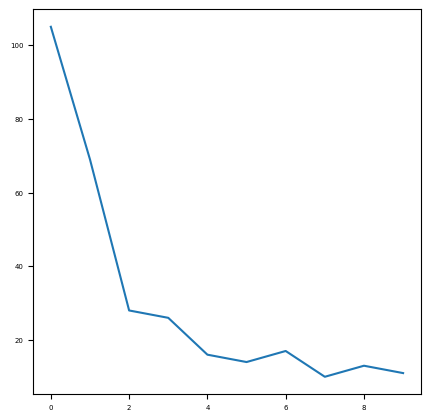

In [30]:

num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)
exemples_dim = len(sentences)
batch_size = 300
epochs = 10

optimizer = Adam()

loss_function = BinaryCrossentropy()
additional_metrics = [
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.6),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

model = Sequential()
model.add(Embedding(
    input_dim=input_dim,
    output_dim=output_dim,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.random_normal
))
model.add(SimpleRNN(units=3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
#model.summary()

weight_for_0 = (1 / qtd_neg) * (exemples_dim / 3.0)
weight_for_1 = (1 / qtd_pos) * (exemples_dim / 3.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

history = model.fit(X, y, class_weight=class_weight, batch_size=batch_size, shuffle=True, epochs=epochs, verbose=True)

plt.figure()
plt.plot(history.history['fn'])
plt.show()

In [ ]:
# Exemplo de inferência
novo_X = [['desenvolvedor', 'web', 'java','junior']]
novo_X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], novo_X))
novo_X = pad_sequences(novo_X, maxlen=maxlen, padding='post')
y_pred = model.predict(novo_X, batch_size=1)[0]
y_pred

In [31]:
model.save("model.keras")